In [1]:
from pyproj import Proj
import numpy as np 
import matplotlib.pyplot as plt 
import geopandas as gpd

In [2]:
# initialize a projection with the projection type, proj
# and the reference ellipse, ellps (ref. ellipse is the ellipse on which lat/lon points are defined)
# WGS84 = World Geodetic System 1984 standard, used for GPS points 
p=Proj(proj='hammer',ellps='WGS84') 
lon=-120.5 
lat=42.4
x,y=p(lon,lat)
print('(lon,lat) -> (x,y) : ('+str(lon)+','+str(lat)+') ->('+str(x)+','+str(y)+')')

(lon,lat) -> (x,y) : (-120.5,42.4) ->(-9894366.0792,5203184.81636)


In [3]:
# build latitude/longitude grid 
lon_lines=np.linspace(-180,180,20) # line of longitude at every point 
lat_lines=np.linspace(-90,90,20) # line of latitude at every point 


In [4]:
def buildLatLonGrid(lon_lines,lat_lines,n_lats,n_lons,lat_rng=[-90,90],lon_rng=[-180,180]):
    '''
    buildLatLonGrid(lon_lines,lat_lines,n_lats,n_lons,lat_rng=[-90,90],lon_rng=[-180,180])
    
    Parameters
    ----------
    lon_lines : list or array of longitude points to have a latitude line 
    lat_lines : list or array of latitude points to have a longitude line 
    n_lats : number of points for a latitude line 
    n_lons : number of points for a longitude line 
    lat_rng : 2 element list with min/max latitude for latitude lines (optional, default [-90,90])
    lon_rng : 2 element list with min/max longitude for longitude lines (optional, default [-180,180])
    
    Returns
    -------
    llgrid : dictionary with following fields:
            {'lons':[list of np arrays for longitudes],'lats':[list of np arrays for latitudes],
             'lat_range':np array of latitude range for a longitude line,
             'lon_range':np array of longitude range for a latitude line}
    '''
    llgrid={'lons':[],'lats':[]}
    
    llgrid['lat_range']=np.linspace(lat_rng[0],lat_rng[1],n_lats) # lat pts to plot along a lon line 
    llgrid['lon_range']=np.linspace(lon_rng[0],lon_rng[1],n_lons) # lon pts to plot along a lat line 
    lat_range_sz=llgrid['lon_range'].shape
    lon_range_sz=llgrid['lat_range'].shape
    for lon in lon_lines:
        llgrid['lons'].append(lon*np.ones(lon_range_sz)    )
    for lat in lat_lines:
        llgrid['lats'].append(lat*np.ones(lat_range_sz))
        
    return llgrid 

llgrid=buildLatLonGrid(lon_lines,lat_lines,180,360)

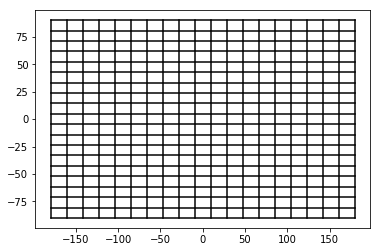

In [5]:
# naively plot the grid in cartesian 
fig=plt.figure()
for lon_line in llgrid['lons']:
    plt.plot(lon_line,llgrid['lat_range'],'k')
for lat_line in llgrid['lats']:
    plt.plot(llgrid['lon_range'],lat_line,'k')

plt.show()

In [6]:
def projectGrid(llgrid,proj_in='hammer',ellps_in='WGS84',lon_0=0):
    '''
    projectGrid
    
    projects llgrid from buildLatLonGrid() 
    
    Parameters
    ----------
    llgrid: output from buildLatLonGrid() on WGS84 grid
    proj_in: the projection to move to (default 'hammer')
    ellps_in: ref ellipse to move from (default 'WGS84')
    
    Returns 
    -------
    projectedGrid: list of dictionary {'x':xvals,'y':yvals} for each lat or lon line
    '''
    p = Proj(proj=proj_in,ellps=ellps_in,lon_0=lon_0)
    
    projectedGrid=[]
    for lon_line in llgrid['lons']:    
        x,y= p(lon_line,llgrid['lat_range'])
        projectedGrid.append({'x':x,'y':y})
    
    for lat_line in llgrid['lats']:
        x,y= p(llgrid['lon_range'],lat_line)
        projectedGrid.append({'x':x,'y':y})
    
    return projectedGrid

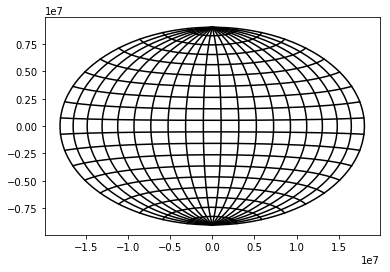

In [7]:
# transform the lat/lon grid to cartesian with projection 
projGrid=projectGrid(llgrid,'hammer') # returns list of x-y dicts
for ln in projGrid:
    plt.plot(ln['x'],ln['y'],'k')    
plt.show()

notice the axes above are now in meters! 

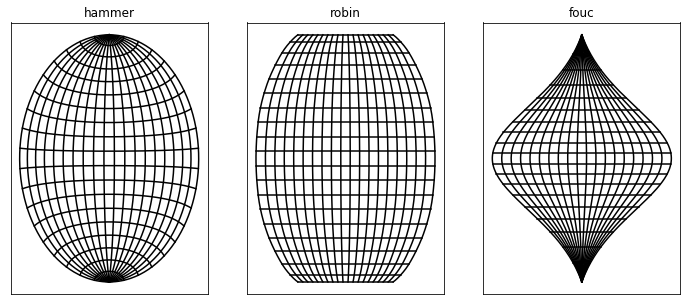

In [8]:
# you can also initialize the Proj class with a dictionary! 
# here, it loops over a number of projection dictionaries and plots each
projs=['hammer','robin','fouc']
isubpl=1
plt.figure(figsize=[12,5])
for projtype in projs: 
    projGrid=projectGrid(llgrid,projtype) # returns list of x-y dicts    
    ax=plt.subplot(1,len(projs),isubpl)
    isubpl=isubpl+1
    for ln in projGrid:
        plt.plot(ln['x'],ln['y'],'k')
    plt.title(projtype)    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

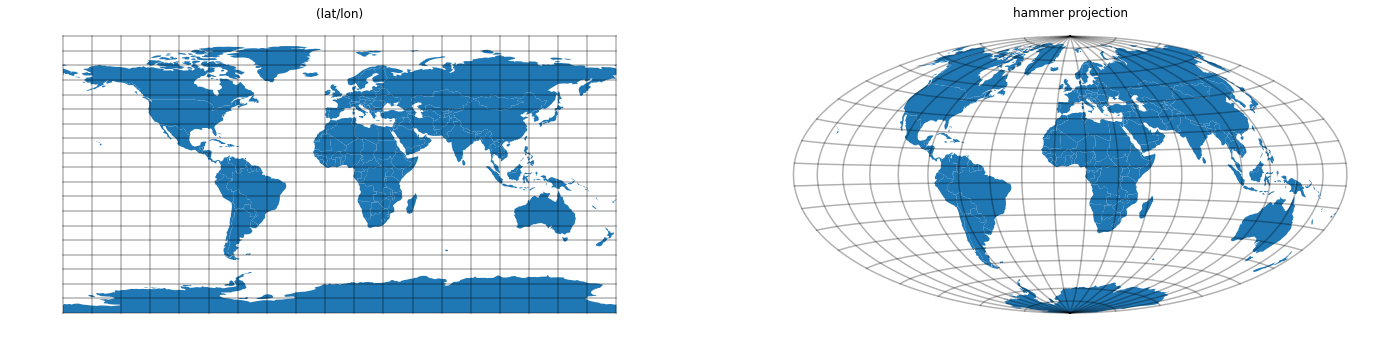

In [9]:
# use geopandas to plot some shapes, pyproj to overplot lat/lon lines  

# plot a shapely polygon with lat/lon coords on map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = {'init': 'epsg:4326'} # note that epsg:4326 is the same as WGS84

plt.figure(figsize=[24,10])

# raw cartesian 
ax=plt.subplot(1,2,1)
world.plot(ax=ax)
for lon_line in llgrid['lons']:
    plt.plot(lon_line,llgrid['lat_range'],'k',alpha=0.3)
for lat_line in llgrid['lats']:
    plt.plot(llgrid['lon_range'],lat_line,'k',alpha=0.3)
ax.set_title("(lat/lon)");

# hammer projection
world_hammer = world.to_crs({'proj':'hammer', 'ellps':'WGS84'})
projGrid=projectGrid(llgrid,'hammer') # returns list of x-y dicts
ax2=plt.subplot(1,2,2)
world_hammer.plot(ax=ax2)
for ln in projGrid:
    ax2.plot(ln['x'],ln['y'],'k',alpha=0.3) 
ax2.set_title("hammer projection")

for axi in [ax,ax2]: 
    axi.axis('off')
plt.show()

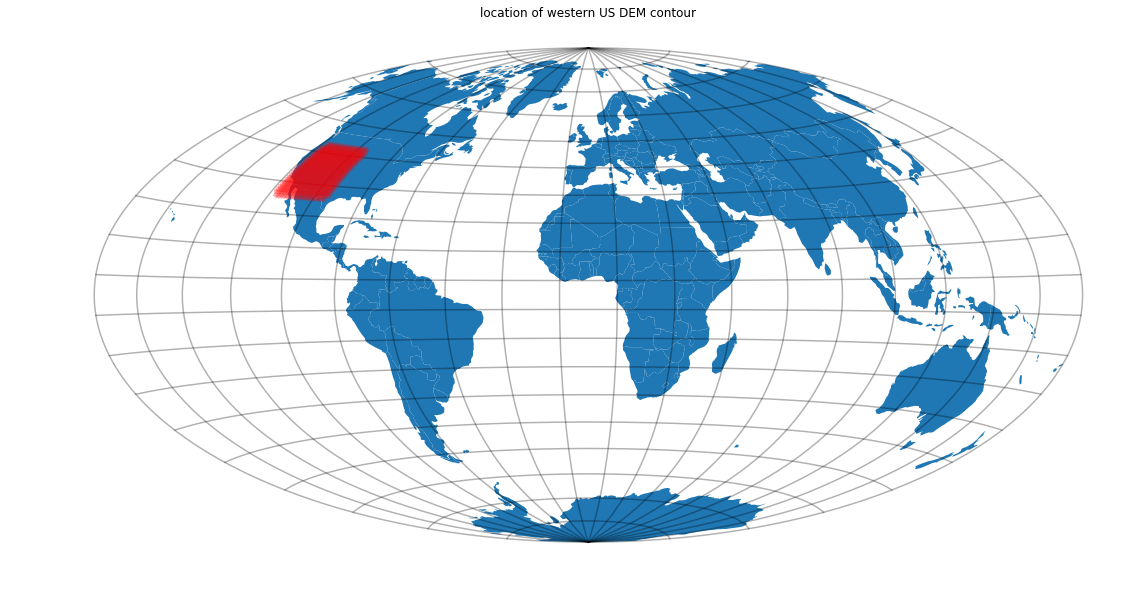

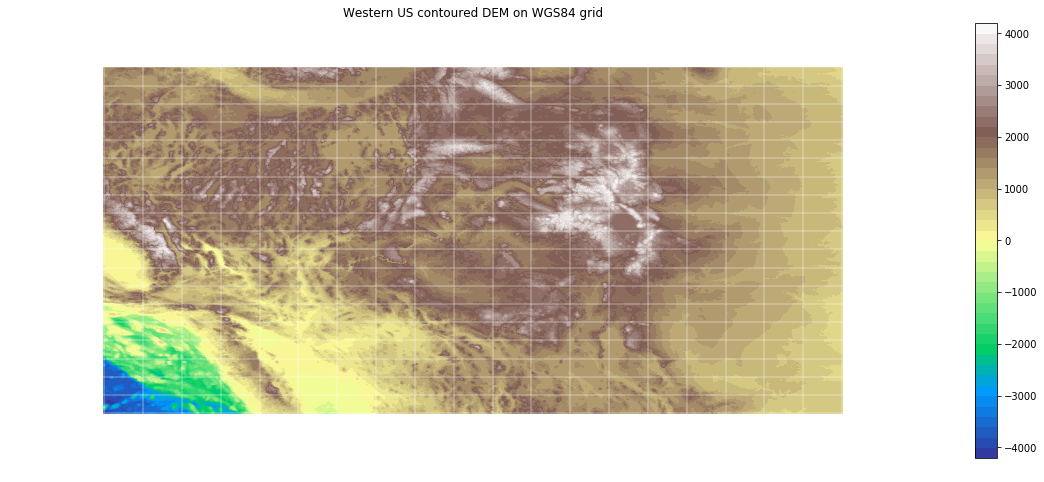

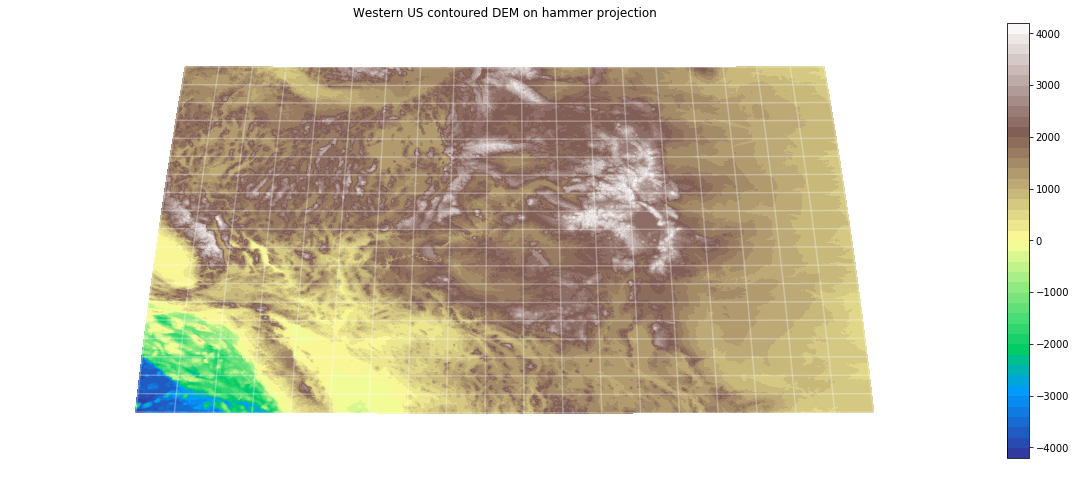

In [11]:
# plot a contour on a projected map!

from resources.etopo1support import etopo
import os


proj_type='hammer'
world_proj = world.to_crs({'proj':proj_type, 'ellps':'WGS84'})
projGrid=projectGrid(llgrid,proj_type)

# plot locator map
plt.figure(figsize=(20,10))

ax1=plt.gca()
world_proj.plot(ax=ax1) # countries 
for ln in projGrid:
    ax1.plot(ln['x'],ln['y'],'k',alpha=0.3) # global lat/lon grid
     
# build/plot local lat/lon grid        
lon_lines=np.linspace(-120,-100,20) # line of longitude at every point 
lat_lines=np.linspace(30,44,20) # line of latitude at every point 
llgrid2=buildLatLonGrid(lon_lines,lat_lines,50,55,lat_rng=[29,45],lon_rng=[-121,-99])
projGrid=projectGrid(llgrid2,proj_type)
for ln in projGrid:
    ax1.plot(ln['x'],ln['y'],'r',alpha=.3,linewidth=5)   
plt.title("location of western US DEM contour")    
ax1.axis('off')

plt.show()
topo_file='../data/elevation_data/etopo1.asc'

# load western US elevation data downloaded/modified from https://www.ngdc.noaa.gov/mgg/global/global.html
if os.path.isfile(topo_file):
    topo=etopo(topo_file) 
    
    # build and project meshgrid of lon/lat points
    LonG,LatG=np.meshgrid(topo.lons,topo.lats)          
    lon_0=-110 # viewing at -110! 
    p = Proj(proj=proj_type,ellps='WGS84',lon_0=lon_0)
    xlons,xlats=p(LonG,LatG)
    projGrid=projectGrid(llgrid2,proj_type,lon_0=lon_0) # the lat/lon grid
    
    # raw contour plot 
    plt.figure(figsize=[20,8])
    plt.contourf(topo.lons,topo.lats,topo.topo,50,cmap='terrain')        
    for lon_line in llgrid2['lons']:
        plt.plot(lon_line,llgrid2['lat_range'],'w',alpha=0.3)
    for lat_line in llgrid2['lats']:
        plt.plot(llgrid2['lon_range'],lat_line,'w',alpha=0.3)
    plt.colorbar()    
    plt.gca().axis('off')
    plt.title('Western US contoured DEM on WGS84 grid')
    plt.show()
    
    # contour the elevation on the projected grid!
    plt.figure(figsize=[20,8])                 
    plt.contourf(xlons,xlats,topo.topo,50,cmap='terrain')        
    for ln in projGrid:
        plt.plot(ln['x'],ln['y'],'w',alpha=0.3)
    plt.colorbar()          
    plt.gca().axis('off')
    plt.title('Western US contoured DEM on hammer projection')
    plt.show()